# Gradient Boosting

An ensemble model from scikit-learn.

## Introduction

After some tries with Random Forest, we thought about trying other ensemble models. Searching into scikit-learn, we found out about Gradient Boosting models.

**Definitions** 
* **Ensemble models** combine multiple individual models to create a more robust and accurate predictor. They work by aggregating predictions from different base models, reducing overfitting and variance.
* **Gradient Boosting** (from scikit-learn web): This algorithm builds an additive model in a forward stage-wise fashion; it allows for the optimization of arbitrary differentiable loss functions. In each stage n_classes_ regression trees are fit on the negative gradient of the loss function, e.g. binary or multiclass log loss. Binary classification is a special case where only a single regression tree is induced. `HistGradientBoostingClassifier` is a much faster variant of this algorithm for larger datasets.

From this definition we used HistGradientBoosting for a better performance, as our dataset contains approximately 26700 instances.


### Deepen on Gradient Boosting

Let's break it down in the simplest way: *What is "gradient boosting"?*

Gradient boosting is an ensemble method that creates multiple weak mini-models and later combine them into a bigger one to get better performance as a whole. Those mini-models are usually decision trees (scikit-learn does not specify it) and are built sequentially so each tree tries to correct the mistakes made by the previous one. Gradient descent is used to minimize the loss function and adjust the model. 
> United we stand, divided we fall.

This model can be used for regression and classification problems as it can find any non linear relationship between targets and features.
Some advantages of these models are: dealing with missing values (although in our case we have already dealt with them), not influenced by outliers, not influenced by high cardinality (it is no neccessary to standardize data, unlike neural networks).

**COMPARISON WITH RANDOM FOREST**

Both are ensemble methods that rely on trees however, here are some differences:

* Training: random forest uses parallel training, while gradient boosting uses sequential training.
* Overfitting: gradient boosting captures better the nuances of the problem but it can be more prone to overfitting.

## Methodology

Same procedure as in `MLPClassifier` and `Random Forest` but with different hyperparameters.

## Implementation

In [15]:
#import libraries
import pandas as pd
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from mlflow.create_dataset import Dataset
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, roc_curve
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.multioutput import MultiOutputClassifier
import matplotlib.pyplot as plt

In [16]:
# import datasets
from mlflow.create_dataset import Dataset

data = Dataset()
X, y = data.with_correlation()
output = data.test

In [17]:
# initialize model
model_to_train = MultiOutputClassifier(HistGradientBoostingClassifier(early_stopping=True), n_jobs=-1)


In [18]:
# hyperparameters optimization
param_dist_random = {
                'estimator__max_depth': [None, 10, 25, 50, 75, 100],
                'estimator__min_samples_leaf': randint(5, 50),
                'estimator__learning_rate': uniform(0.001, 0.2),
                'estimator__max_iter': randint(50, 500),
                'estimator__l2_regularization': uniform(0.001, 0.01),
                'estimator__max_bins': [50, 100, 200, 255],
    }
random_search = RandomizedSearchCV(estimator=model_to_train, param_distributions=param_dist_random,
                                    n_iter=100, cv=5, n_jobs=-1, verbose=1,
                                    scoring='roc_auc')

Hyperparameters description:

* `max_depth`: controls the complexity of each individual decision tree by limiting the number of splits from root to leaf. A deeper tree can capture more complex relationships but risks overfitting.

* `min_samples_leaf`: sets a lower bound on how many training samples must exist in each leaf node. This means that at each leaf represents a meaningful group of samples rather than just a few outliers.

* `learning_rate`: determines how much each tree contributes to the final model. A smaller learning rate means each tree has less influence, requiring more trees to achieve the same level of performance.

* `max_iter`: The number of estimators parameter sets the maximum number of trees in your ensemble. For binary classification tasks, this directly corresponds to the number of boosting iterations. 

* `l2_regularization`: prevents overfitting.

* `max_bins`: controls how continuous features are discretized during training. (Actually we don't have any continuous feature, will this be applied?)

In [19]:
# Split the dataset into train and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

In [ ]:
# train model
# WARNING: time 6 min
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_
print('Best parameters found by random search:', random_search.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


Best parameters found by random search: {'estimator__l2_regularization': np.float64(0.0069728110198935996), 'estimator__learning_rate': np.float64(0.019806470979605174), 'estimator__max_bins': 255, 'estimator__max_depth': 50, 'estimator__max_iter': 358, 'estimator__min_samples_leaf': 27}


In [21]:
# predict on test set
y_pred = best_model.predict(X_test)

In [22]:
################ METRICS ################
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred, average="macro")
f1 = f1_score(y_test, y_pred, average="macro")
print(f'Accuracy: {accuracy}')
print(f'ROC AUC: {roc_auc}')
print(f'F1: {f1}')

Accuracy: 0.6842630725071759
ROC AUC: 0.747658477234936
F1: 0.6694272722716408


In [23]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.72      0.48      0.58      1702
           1       0.78      0.75      0.76      3731

   micro avg       0.76      0.66      0.71      5433
   macro avg       0.75      0.62      0.67      5433
weighted avg       0.76      0.66      0.70      5433
 samples avg       0.35      0.33      0.33      5433



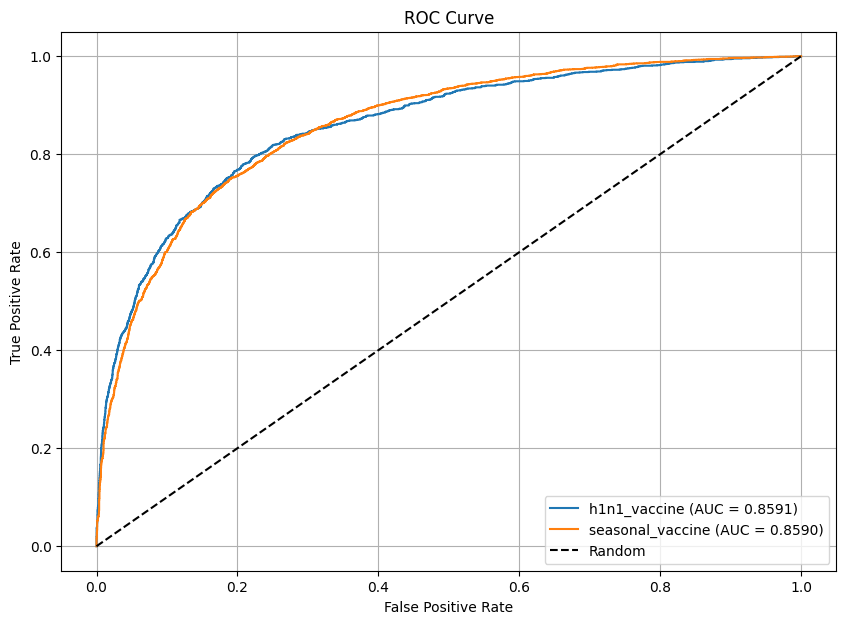

In [30]:
# Get predicted probabilities
y_scores = [m.predict_proba(X_test)[:, 1] for m in best_model.estimators_]

# Plot ROC-AUC for each output label
plt.figure(figsize=(10, 7))
for i, y_score in enumerate(y_scores):
    fpr, tpr, _ = roc_curve(y_test.iloc[:, i], y_score)
    auc = roc_auc_score(y_test.iloc[:, i], y_score)
    plt.plot(fpr, tpr, label=f'{y_test.columns[i]} (AUC = {auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--', label="Random")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [ ]:
# competition submission
predictions = best_model.predict_proba(output)
        
h1n1_probs = predictions[0][:, 1]  # Probabilities of positive class for h1n1_vaccine
seasonal_probs = predictions[1][:, 1]  # Probabilities of positive class for seasonal_vaccine
predict = pd.DataFrame({
            "respondent_id": output.index,
            "h1n1_vaccine": h1n1_probs,
            "seasonal_vaccine": seasonal_probs
})
predict.set_index("respondent_id", inplace=True)
predict.head()

In [ ]:
# predict.to_csv("predictions.csv")

## Results

